In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, brier_score_loss

In [ ]:
# CELL 1: load processed datasets created earlier
data_m   = pd.read_csv("../../../data/processed/us_macro_monthly.csv", index_col=0, parse_dates=True)
factors  = pd.read_csv("../../../data/processed/yield_curve_factors.csv", index_col=0, parse_dates=True)

# Merge + ensure monthly freq + create 2s10s if missing
df = pd.concat([data_m, factors], axis=1).sort_index().asfreq("ME")
if {"DGS10","DGS2"}.issubset(df.columns) and "spread_10y_2y" not in df:
    df["spread_10y_2y"] = df["DGS10"] - df["DGS2"]

# Basic hygiene: forward-fill macro gaps
df = df.ffill()
df

In [ ]:
# CELL 2: build t+H recession targets
H_LIST = [6, 12, 18]     # we'll evaluate all three horizons
for H in H_LIST:
    df[f"recession_t+{H}"] = df["USREC"].astype(int).shift(-H)

# Drop rows with unknown future labels for the longest horizon
df = df.dropna(subset=[f"recession_t+{max(H_LIST)}"])
df

In [ ]:
# CELL 2: build t+H recession targets
H_LIST = [6, 12, 18]     # we'll evaluate all three horizons
for H in H_LIST:
    df[f"recession_t+{H}"] = df["USREC"].astype(int).shift(-H)

# Drop rows with unknown future labels for the longest horizon
df = df.dropna(subset=[f"recession_t+{max(H_LIST)}"])
df

In [ ]:
# CELL 3: choose features
FEATS = ["PC2_Slope", "inflation_yoy", "UNRATE", "m2_growth_yoy"]
assert set(FEATS).issubset(df.columns), "Missing features. Check your earlier notebooks."

# Quick sanity
df[FEATS].describe().T

In [12]:
# CELL 4: import helper
from research.interest_rates.scripts.model_utils import oos_multivariate

df_clean = df.copy()

# 1. Keep only rows with all needed columns non-missing
needed_cols = FEATS + [f"recession_t+{H}" for H in H_LIST]
df_clean = df_clean.dropna(subset=needed_cols)

# 2. (Optional) forward/back fill remaining occasional gaps if you prefer not to drop
# df_clean = df_clean.ffill().bfill()

# 3. Sanity check
print("Rows before:", len(df))
print("Rows after cleaning:", len(df_clean))
print("Any NaNs left?", df_clean[needed_cols].isna().any().any())

# Use df_clean for all later cells
df = df_clean

Rows before: 766
Rows after cleaning: 490
Any NaNs left? False


In [13]:
# CELL 5: run across horizons
results = {}
for H in H_LIST:
    oos, _ = oos_multivariate(df, FEATS, f"recession_t+{H}", start_idx=180, C=1.0)
    auc = roc_auc_score(oos["y"], oos["phat"])
    ap  = average_precision_score(oos["y"], oos["phat"])
    brier = brier_score_loss(oos["y"], oos["phat"])
    results[H] = {"oos": oos, "AUC": auc, "AP": ap, "Brier": brier}

pd.DataFrame({H: {k:v for k,v in res.items() if k!='oos'} for H,res in results.items()})


,6,12,18
AUC,0.774696,0.807497,0.848911
AP,0.193737,0.213207,0.242605
Brier,0.165534,0.183023,0.166668


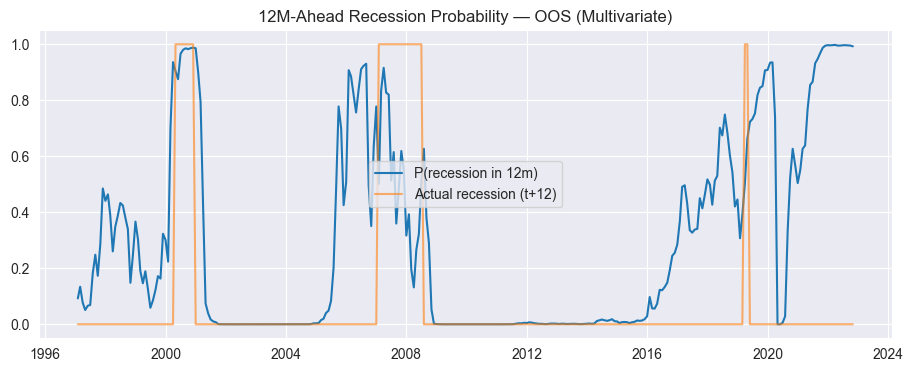

In [14]:
# CELL 6: probability timeline (12m as default)
H = 12
oos12 = results[H]["oos"]
plt.figure(figsize=(11,4))
plt.plot(oos12.index, oos12["phat"], label=f"P(recession in {H}m)")
plt.plot(oos12.index, oos12["y"], label=f"Actual recession (t+{H})", alpha=0.6)
plt.title(f"{H}M-Ahead Recession Probability — OOS (Multivariate)")
plt.legend(); plt.show()


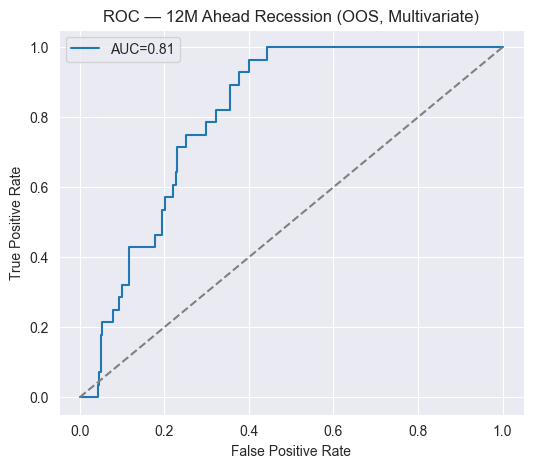

In [16]:
# CELL 7: ROC + PR for 12m
from sklearn.metrics import PrecisionRecallDisplay

fpr, tpr, thr = roc_curve(oos12["y"], oos12["phat"])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={results[12]['AUC']:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — 12M Ahead Recession (OOS, Multivariate)")
plt.legend()
plt.show()


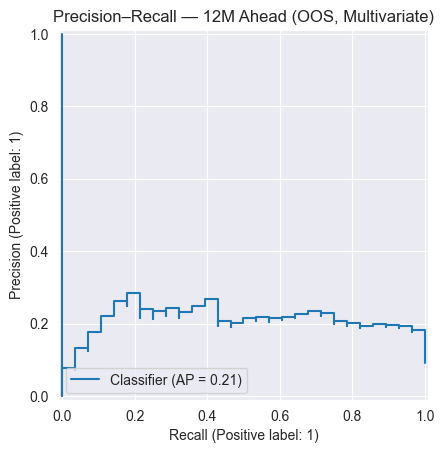

In [17]:
PrecisionRecallDisplay.from_predictions(oos12["y"], oos12["phat"])
plt.title("Precision–Recall — 12M Ahead (OOS, Multivariate)")
plt.show()

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_3984/1821607856.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = oos12.groupby(cats)["y"].mean()
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_3984/1821607856.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt = oos12.groupby(cats)["y"].size()


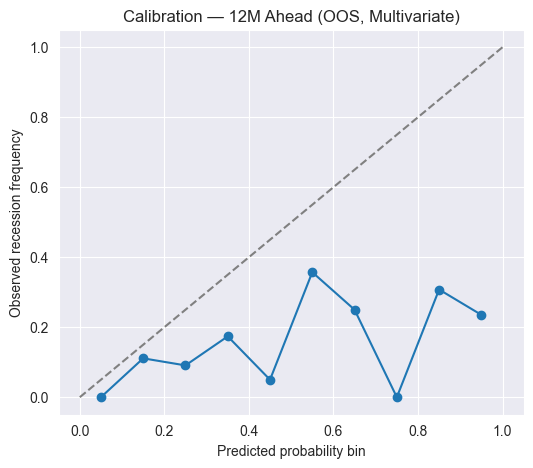

,bin_center,obs_freq,count
0,0.05,0.000000,153
1,0.15,0.111111,18
2,0.25,0.090909,11
3,0.35,0.173913,23
4,0.45,0.050000,20
5,0.55,0.357143,14
6,0.65,0.250000,12
7,0.75,0.000000,12
8,0.85,0.307692,13
9,0.95,0.235294,34


In [18]:
# CELL 8: reliability / calibration plot
bins = np.linspace(0,1,11)
cats = pd.cut(oos12["phat"], bins, include_lowest=True)
cal = oos12.groupby(cats)["y"].mean()
cnt = oos12.groupby(cats)["y"].size()
centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(6,5))
plt.plot([0,1],[0,1],'--', color='gray')
plt.plot(centers, cal.values, marker='o')
plt.xlabel("Predicted probability bin")
plt.ylabel("Observed recession frequency")
plt.title("Calibration — 12M Ahead (OOS, Multivariate)")
plt.show()

pd.DataFrame({"bin_center": centers, "obs_freq": cal.values, "count": cnt.values})

In [19]:
# CELL 9: choose threshold by Youden J on OOS
fpr, tpr, thr = roc_curve(oos12["y"], oos12["phat"])
j = np.argmax(tpr - fpr)
thr_star = thr[j]
pred = (oos12["phat"] >= thr_star).astype(int)

TP = int(((pred==1)&(oos12["y"]==1)).sum())
FP = int(((pred==1)&(oos12["y"]==0)).sum())
TN = int(((pred==0)&(oos12["y"]==0)).sum())
FN = int(((pred==0)&(oos12["y"]==1)).sum())

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)

print(f"Thr*={thr_star:.2f} | TP={TP} FP={FP} TN={TN} FN={FN} | Precision={precision:.2f} Recall={recall:.2f}")

Thr*=0.20 | TP=27 FP=113 TN=169 FN=1 | Precision=0.19 Recall=0.96


In [20]:
# CELL 10: grid over C (L2 strength); lower C = stronger regularization
C_grid = [0.2, 0.5, 1.0, 2.0]
grid = []
for C in C_grid:
    oosC, _ = oos_multivariate(df, FEATS, "recession_t+12", start_idx=180, C=C)
    auc = roc_auc_score(oosC["y"], oosC["phat"])
    ap  = average_precision_score(oosC["y"], oosC["phat"])
    grid.append({"C": C, "AUC": auc, "AP": ap, "n": len(oosC)})
    
pd.DataFrame(grid).sort_values("AUC", ascending=False)

,C,AUC,AP,n
0,0.2,0.813956,0.217508,310
1,0.5,0.810537,0.215140,310
2,1.0,0.807497,0.213207,310
3,2.0,0.805851,0.215326,310


In [21]:
# CELL 11: persist predictions & metrics
out_tbl = []
for H, res in results.items():
    res["oos"].to_csv(f"../../../data/processed/recession_prob_{H}m_oos_multivar.csv")
    out_tbl.append({"horizon": H, "AUC": res["AUC"], "AP": res["AP"], "Brier": res["Brier"], "n": len(res["oos"])})
    
pd.DataFrame(out_tbl).to_csv("../../../data/models/oos_metrics_05.csv", index=False)
print("Saved: data/processed/recession_prob_[6|12|18]m_oos_multivar.csv and data/models/oos_metrics_05.csv")

Saved: data/processed/recession_prob_[6|12|18]m_oos_multivar.csv and data/models/oos_metrics_05.csv
